In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
seed_experiment_results = pd.read_csv('evaluate/seed-experiment-results/aggregate/aggregate-seed-experiment-results-040920.csv')

In [4]:
seed_experiment_results

,seed,language_pair,bleu,bpe
0,10,en-ne,4.42,2500
1,10,en-si,1.64,2500
2,10,ne-en,7.59,2500
3,10,si-en,6.69,2500
4,11,en-ne,4.33,2500
...,...,...,...,...
95,13,si-en,6.88,7500
96,14,en-ne,4.54,7500
97,14,en-si,1.26,7500
98,14,ne-en,7.31,7500


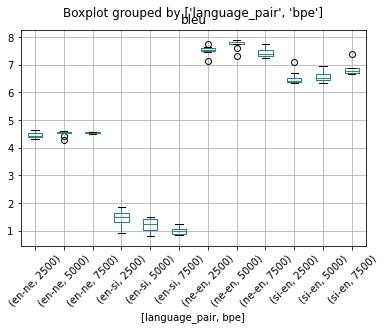

In [5]:
seed_experiment_results\
    .drop('seed', 1)\
    .set_index('bpe')\
    .boxplot(by=['language_pair','bpe'], rot=45)

In [6]:
import seaborn as sns

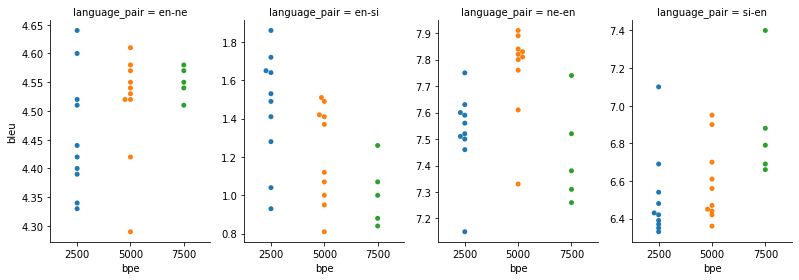

In [25]:
sns.catplot(x="bpe", y="bleu", col="language_pair",
            data=seed_experiment_results, kind="swarm",
            height=4, aspect=.7, sharex=False, sharey=False);

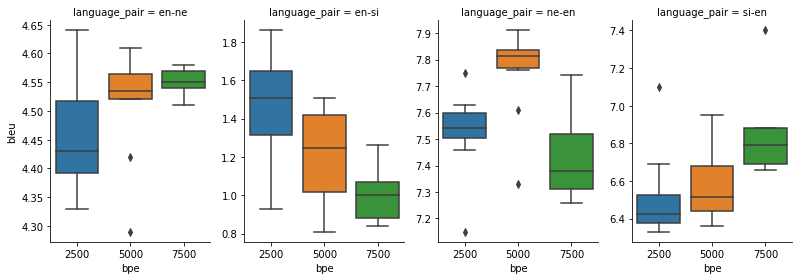

In [24]:
sns.catplot(x="bpe", y="bleu", col="language_pair",
            data=seed_experiment_results, kind="box",
            height=4, aspect=.7, sharex=False, sharey=False);

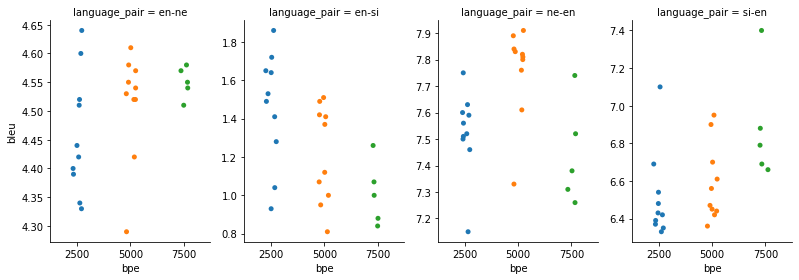

In [23]:
sns.catplot(x="bpe", y="bleu", col="language_pair",
            data=seed_experiment_results, kind="strip",
            height=4, aspect=.7, sharex=False, sharey=False)

It seems to me like even though the boxplots that do not share axes seem to be showing some sort of "trends" when we look at just the boxes, the swarm/scatter plots show just about how random the data is. Maybe there is a nonzero difference between the means (in fact there always is if you have enough precision (c) J. Tukey) but I would argue it doesn't necessarily **matter**.